## **Imports**


In [210]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os

## **Preprocessing and Conversion from .Wav to Spectrogram**

In [115]:
major_samp = os.path.join('Audio_Files','Major','Major_0.wav')
minor_samp = os.path.join('Audio_Files','Minor','Minor_0.wav')

In [116]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
    wav = tf.squeeze(wav,axis=1)
    sample_rate = tf.cast(sample_rate,dtype =tf.int64)
    wav = tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav


In [117]:
loaded_major_samp = load_wav_16k_mono(major_samp)
loaded_minor_samp = load_wav_16k_mono(minor_samp)

In [118]:
loaded_major_samp

<tf.Tensor: shape=(36000,), dtype=float32, numpy=
array([ 3.5046114e-08, -1.0862113e-07,  4.8819302e-08, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>

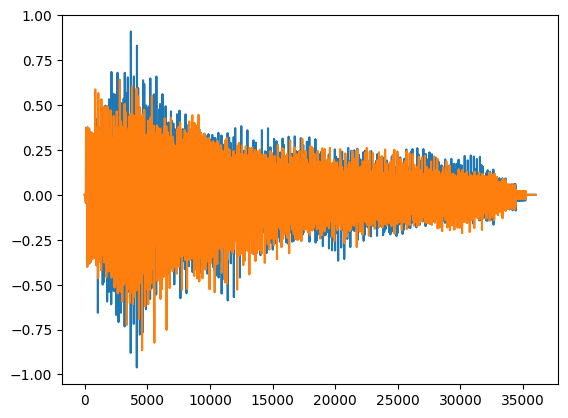

In [119]:
plt.plot(loaded_major_samp)
plt.plot(loaded_minor_samp)
plt.show()

In [120]:
Major_file = os.path.join('Audio_Files','Major')
Minor_file = os.path.join('Audio_Files','Minor')

In [121]:
Major = tf.data.Dataset.list_files(Major_file + '\*.wav')
Minor = tf.data.Dataset.list_files(Minor_file + '\*.wav')

In [183]:
Major_chords = tf.data.Dataset.zip((Major,tf.data.Dataset.from_tensor_slices(tf.ones(len(Major)))))
Minor_chords = tf.data.Dataset.zip((Minor,tf.data.Dataset.from_tensor_slices(tf.zeros(len(Minor)))))
data = Major_chords.concatenate(Minor_chords)

In [123]:
Major_chords.as_numpy_iterator().next()

(b'Audio_Files\\Major\\Major_358.wav', 1.0)

In [124]:
major_lengths = []
for file in os.listdir(os.path.join('Audio_Files','Major')):
    tensor_wave = load_wav_16k_mono(os.path.join('Audio_Files','Major',file))
    major_lengths.append(len(tensor_wave))

minor_lengths = []
for file in os.listdir(os.path.join('Audio_Files','Minor')):
    tensor_wave = load_wav_16k_mono(os.path.join('Audio_Files','Minor',file))
    minor_lengths.append(len(tensor_wave))

In [125]:
tf.math.reduce_min(major_lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=35200>

In [126]:
print(f'major_mean_sec: {np.mean(major_lengths)/16000}= {np.mean(major_lengths)}')
print(f'major_min_sec: {np.min(major_lengths)/16000}= {np.min(major_lengths)}')
print(f'major_max_sec: {np.max(major_lengths)/16000} = {np.max(major_lengths)}')
print(f'minor_mean_sec: {np.mean(minor_lengths)/16000}= {np.mean(minor_lengths)}')
print(f'minor_min_sec:{np.min(minor_lengths)/16000} = {np.min(minor_lengths)}')
print(f'minor_max_sec: {np.max(minor_lengths)/16000} = {np.max(minor_lengths)}')

major_mean_sec: 2.2385348605577686= 35816.5577689243
major_min_sec: 2.2= 35200
major_max_sec: 2.2999375 = 36799
minor_mean_sec: 2.2394796918767508= 35831.67507002801
minor_min_sec:2.15 = 34400
minor_max_sec: 2.2999375 = 36799


In [184]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [185]:
filepath, label = Major_chords.shuffle(buffer_size=1000).as_numpy_iterator().next()

In [186]:
Spectogram,label = preprocess(filepath, label)

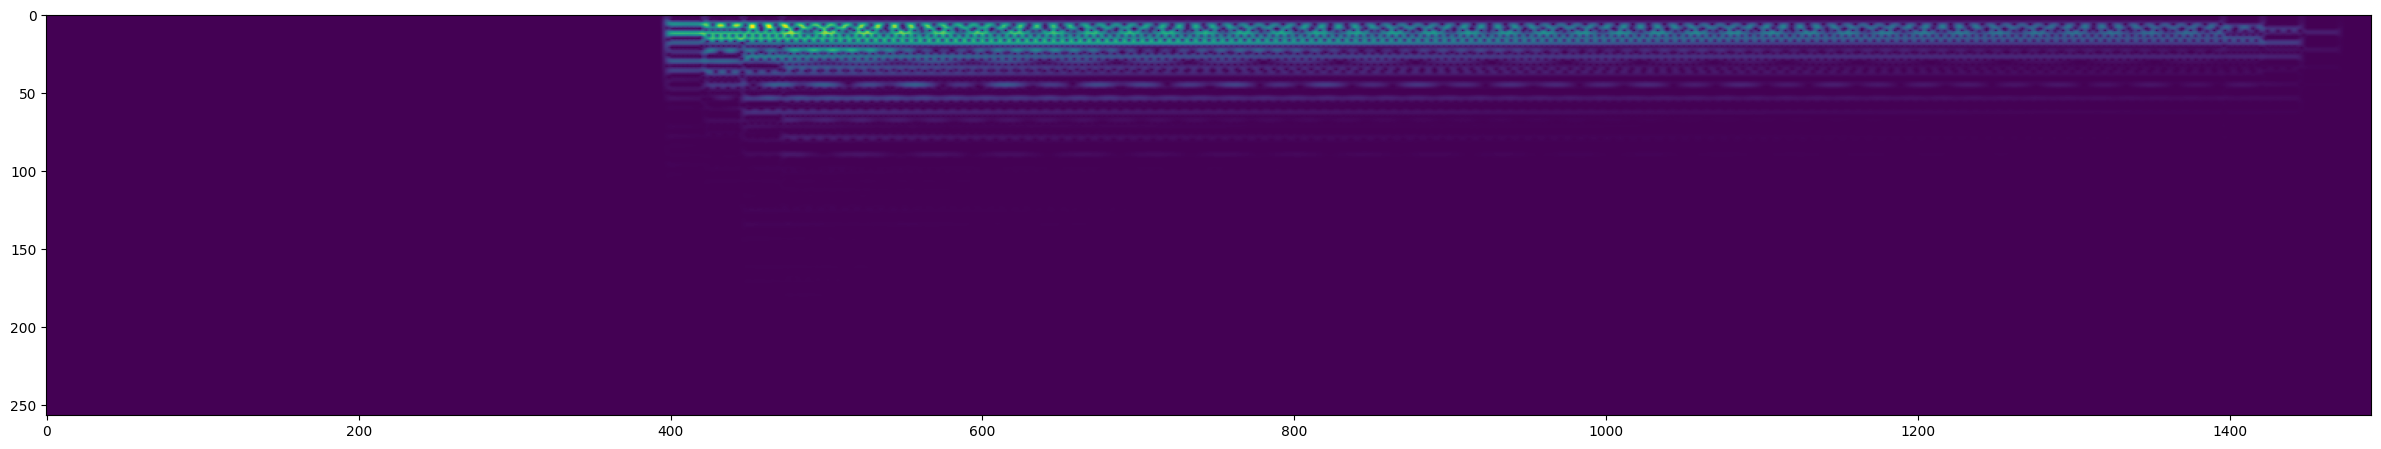

In [187]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(Spectogram)[0])
plt.show()

In [188]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## **Data Segmenting and Modelling**


In [189]:
len(data)

54

In [190]:
train = data.take(40)
test = data.skip(38).take(14)

In [191]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [197]:
Chord_model = Sequential([
    Conv2D(16,(3,3),activation = 'relu', input_shape =(1491, 257, 1)),
    MaxPooling2D(),
    Conv2D(16,(3,3),activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(1,'sigmoid')
])

In [198]:
Chord_model.compile(optimizer='Adam',
    loss = 'BinaryCrossentropy',
    metrics = [tf.keras.metrics.Recall(),
                tf.keras.metrics.Precision()])

In [199]:
Chord_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 744, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 368032)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [200]:
history = Chord_model.fit(train,epochs=5,validation_data=test)

Epoch 1/5
40/40 [==============================] - 112s 3s/step - loss: 1.9711 - recall_1: 0.5027 - precision_1: 0.5937 - val_loss: 0.6684 - val_recall_1: 0.9016 - val_precision_1: 0.5699
Epoch 2/5
40/40 [==============================] - 100s 2s/step - loss: 0.6118 - recall_1: 0.8369 - precision_1: 0.6660 - val_loss: 0.6788 - val_recall_1: 1.0000 - val_precision_1: 0.5826
Epoch 3/5
40/40 [==============================] - 97s 2s/step - loss: 0.5004 - recall_1: 0.8359 - precision_1: 0.7716 - val_loss: 0.4472 - val_recall_1: 0.9028 - val_precision_1: 0.8844
Epoch 4/5
40/40 [==============================] - 109s 3s/step - loss: 0.3811 - recall_1: 0.9043 - precision_1: 0.8313 - val_loss: 0.2622 - val_recall_1: 0.9773 - val_precision_1: 0.8716
Epoch 5/5
40/40 [==============================] - 131s 3s/step - loss: 0.2535 - recall_1: 0.9452 - precision_1: 0.9095 - val_loss: 0.2058 - val_recall_1: 0.9927 - val_precision_1: 0.9379


In [201]:
history.history

{'loss': [1.9711326360702515,
  0.6117610335350037,
  0.5004262328147888,
  0.38114356994628906,
  0.25348055362701416],
 'recall_1': [0.5026881694793701,
  0.8368983864784241,
  0.8359375,
  0.9042553305625916,
  0.9451696872711182],
 'precision_1': [0.5936508178710938,
  0.6659574508666992,
  0.7716346383094788,
  0.8312958478927612,
  0.909547746181488],
 'val_loss': [0.6684285402297974,
  0.6788155436515808,
  0.4472229480743408,
  0.26215457916259766,
  0.20584653317928314],
 'val_recall_1': [0.9016393423080444,
  1.0,
  0.9027777910232544,
  0.9772727489471436,
  0.9927007555961609],
 'val_precision_1': [0.5699481964111328,
  0.5825688242912292,
  0.884353756904602,
  0.8716216087341309,
  0.9379310607910156]}

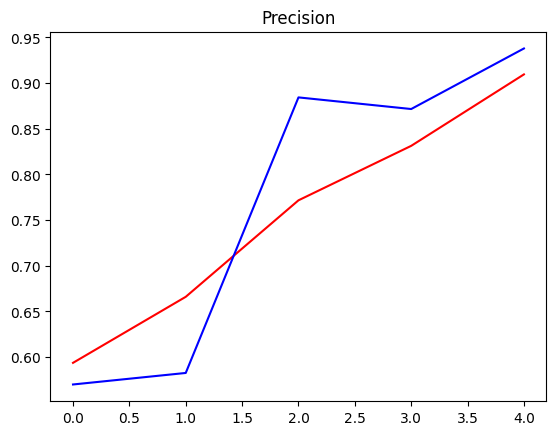

In [214]:
plt.title('Precision')
plt.plot(history.history['precision_1'], 'r')
plt.plot(history.history['val_precision_1'], 'b')
plt.show()

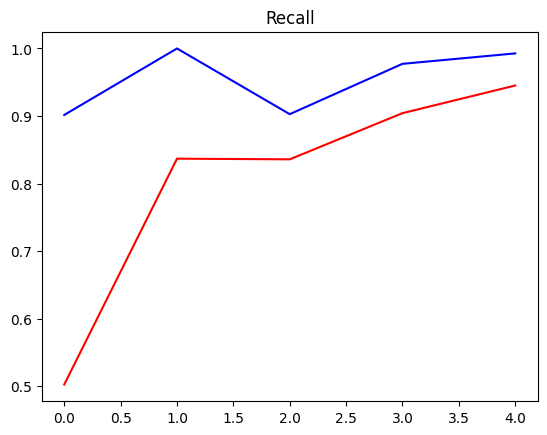

In [215]:
plt.title('Recall')
plt.plot(history.history['recall_1'], 'r')
plt.plot(history.history['val_recall_1'], 'b')
plt.show()

In [203]:
X_test,y_test = test.as_numpy_iterator().next()
yhat = Chord_model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [222]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [225]:
print(f'Accuracy: {spearmanr(yhat,y_test).statistic}')

Accuracy: 0.8783100656536798


### Saving model and loading model

In [ ]:
Chord_model.save('Chord_model.h5')

In [1]:
from tensorflow.keras.models import load_model

In [2]:
Chord_model = load_model('Chord_model.h5')
Chord_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 744, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 368032)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              